<a href="https://colab.research.google.com/github/djdumpling/Machine-Learning-Prince-/blob/main/8_1_MINST_1D_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-_58m_kv1
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-_58m_kv1
  Resolved https://github.com/greydanus/mnist1d to commit 350929d12f4c9a4b7355e0c96604e41b9239bdb4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post9-py3-none-any.whl size=14498 sha256=374533a1569b5fc0333b31997cfce791d1bafaf57c8cffb5a27513dc48349ec7
  Stored in directory: /tmp/pip-ephem-wheel-cache-plesdgmn/wheels/41/95/55/45fcf7d38cfa97e35682da6c5017d4513729131326ce935371
Successfully built mnist1d


In [ ]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

In [ ]:
!mkdir ./sample_data

args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./sample_data/mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

mkdir: cannot create directory ‘./sample_data’: File exists
Did or could not load data from ./sample_data/mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [ ]:
D_i = 40
D_k = 200
D_o = 10

model = nn.Sequential(
  nn.Linear(D_i, D_k),
  nn.ReLU(),
  nn.Linear(D_k, D_k),
  nn.ReLU(),
  nn.Linear(D_k, D_k),
  nn.ReLU(),
  nn.Linear(D_k, D_o))

#He initialization
def weights_init(layer_in):
  # check if layer_in is an instance of nn.Linear, i.e. not nn.ReLU()
  if isinstance(layer_in, nn.Linear):
    # initalize weights with values drawn from a normal distribution, scaled according to num(inputs)
    # the important part of He initalization
    # addresses vanishing/exploding gradient problem
    nn.init.kaiming_normal(layer_in.weight)
    #avoid any initial bias in the network's outputs
    layer_in.bias.data.fill_(0.0)

model.apply(weights_init)

<ipython-input-18-ce1dbc4cd554>:21: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(layer_in.weight)


Sequential(
  (0): Linear(in_features=40, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=200, bias=True)
  (5): ReLU()
  (6): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
# since multiple classes
loss_function = nn.CrossEntropyLoss()
# construct SGD optimizer, initalize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum = 0.9)
# decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size = 10, gamma=0.5)

x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('long'))
x_test  = torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

# load data into class that creates batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=50, shuffle=True, worker_init_fn=np.random.seed(1))

# initalize model weights (again?)
model.apply(weights_init)

n_epoch = 50
# store loss and % correct @ every epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  for i, batch in enumerate(data_loader):
    # retrive inputs and labels
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass
    pred = model(x_batch)
    # compute loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

# Run whole dataset to get statistics
  pred_train = model(x_train)
  pred_test  = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

<ipython-input-18-ce1dbc4cd554>:21: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(layer_in.weight)


Epoch     0, train loss 1.425811, train error 53.08,  test loss 1.559654, test error 61.80
Epoch     1, train loss 1.051797, train error 38.50,  test loss 1.277361, test error 48.70
Epoch     2, train loss 0.830604, train error 29.38,  test loss 1.166072, test error 44.20
Epoch     3, train loss 0.662486, train error 23.85,  test loss 1.102247, test error 41.40
Epoch     4, train loss 0.574761, train error 20.32,  test loss 1.078561, test error 39.40
Epoch     5, train loss 0.417883, train error 14.72,  test loss 0.987323, test error 36.00
Epoch     6, train loss 0.427303, train error 15.22,  test loss 1.115543, test error 36.50
Epoch     7, train loss 0.302814, train error 10.43,  test loss 1.139823, test error 35.80
Epoch     8, train loss 0.298824, train error 10.47,  test loss 1.341079, test error 37.10
Epoch     9, train loss 0.189175, train error 6.38,  test loss 1.151219, test error 33.90
Epoch    10, train loss 0.045818, train error 0.57,  test loss 1.032314, test error 30.10
E

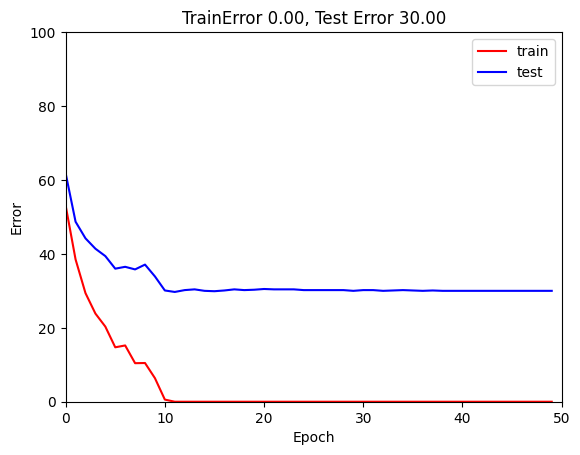

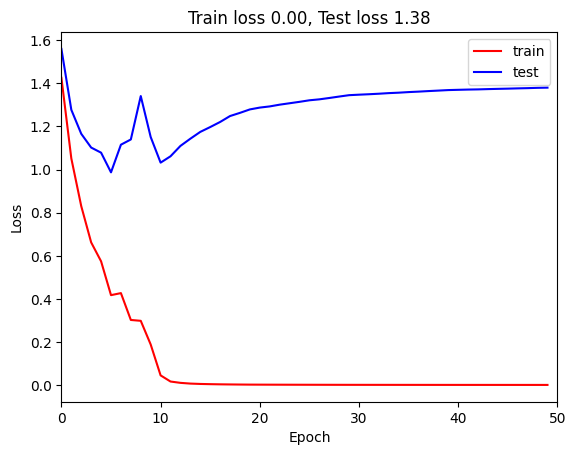

In [ ]:
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()